In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load MNIST dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize images to [-1, 1] range
x_train = x_train / 127.5 - 1.0
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, activation="relu", input_shape=(100,)),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", activation="relu"),
        layers.BatchNormalization(momentum=0.8),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", activation="relu"),
        layers.BatchNormalization(momentum=0.8),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", activation="tanh"),
    ])
    return model


In [ ]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=(28, 28, 1)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ])
    return model


In [ ]:
def build_gan(generator, discriminator):
    discriminator.trainable = False  # We don't want to train the discriminator during GAN training
    model = tf.keras.Sequential([generator, discriminator])
    return model


In [ ]:
# Create the discriminator and compile it
discriminator = build_discriminator()
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Create the generator
generator = build_generator()

# Create the GAN model
gan = build_gan(generator, discriminator)

# Compile the GAN model
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
def train_gan(epochs, batch_size, save_interval):
    # Label smoothing: 0 for real images, 1 for fake images
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # Train the discriminator
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_imgs = x_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Print the progress
        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100*d_loss[1]}] [G loss: {g_loss}]")

        # Save generated images at intervals
        if epoch % save_interval == 0:
            save_generated_images(epoch)

def save_generated_images(epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f"gan_generated_image_epoch_{epoch}.png")
    plt.close()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
0 [D loss: 1.1097816228866577 | D accuracy: 42.457332611083984] [G loss: 0.24120961129665375]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


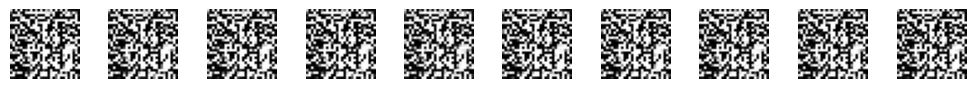

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Train the GAN model
train_gan(epochs=500, batch_size=64, save_interval=1000)


In [ ]:
import matplotlib.pyplot as plt

def save_generated_images(epoch, examples=10, dim=(1, 10), figsize=(10, 1), display=True):
    noise = np.random.normal(0, 1, (examples, 100))  # Latent space vector
    generated_images = generator.predict(noise)  # Generate images from the noise
    generated_images = 0.5 * generated_images + 0.5  # Rescale the generated images to [0, 1]

    if display:
        # Plotting the images
        plt.figure(figsize=figsize)
        for i in range(examples):
            plt.subplot(dim[0], dim[1], i + 1)
            plt.imshow(generated_images[i, :, :, 0], cmap='gray')
            plt.axis('off')  # Turn off axis
        plt.tight_layout()
        plt.show()  # Display images inline

    # Optionally save the images
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"gan_generated_image_epoch_{epoch}.png")
    plt.close()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
0 [D loss: 1.0540492534637451 | D accuracy: 42.5792236328125] [G loss: 0.2696996033191681]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


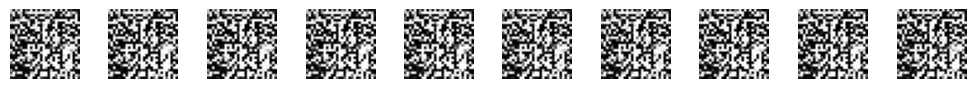

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Train the GAN model
train_gan(epochs=10, batch_size=64, save_interval=1000)
